### Overview:

This notebook aimed is to demonstrate the solution for simple regression problem, predict net profit given a set of attributes, first I start with simple EDA understand the data numerical and categorical distributions. Then I fit simple statistical model followed by linear regression and more complex one. each model includes scoring metrics and explanations.
Finally, I communicate final finding of prediction of the provided Out-of-sample test set and the including factors or attributes that decided the final predictions using shapley values.



In [48]:

%matplotlib inline

# modeling:
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS

# metrics:
from sklearn.model_selection import train_test_split

# model diagnosis:
from yellowbrick.model_selection import learning_curve
from yellowbrick.regressor import ResidualsPlot

# Interpretable Machine Learning:
import shap

# helper functions I wrote for this dataset:
from utils import *


import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from yellowbrick.datasets import load_game
from yellowbrick.model_selection import LearningCurve


import warnings
warnings.filterwarnings('ignore')



In [135]:

from pygments.formatters import HtmlFormatter
formatter = HtmlFormatter(style='default')
with open('ipython.css', 'w') as f:
    f.write(formatter.get_style_defs('.highlight'))



In [49]:

# Settings and aesthetics:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
warnings.filterwarnings('ignore')

# Some basic settings here:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_columns = 30




1. Basic EDA.
2. Feature Engineering.
3. Statistical Model.
4. baseline Model
5. Complex Model.
6. Scoring.
7. SHAPly Values, Interoperable ML.



### EDA

In [50]:

modeling_data = pd.read_csv("../../Data/labeled_dataset.csv")
modeling_data.set_index("index", inplace=True)


In [51]:

modeling_data.head()


,Age,Monthly premium,Socioeconomic category,Monthly kilometers,Coefficient bonus malus,Vehicle type,CRM score,Standard of living,Brand,Yearly income,Credit score,Yearly maintenance cost,Net profit
index,,,,,,,,,,,,,
0,58.0,40.0,Student,973,106,SUV,164,3762,Peugeot,20420,309,801,54.998558
1,26.0,27.0,Labor worker,637,95,5 doors,126,3445,Renault,25750,135,667,7.840930
2,27.0,26.0,Office worker,978,136,SUV,153,986,Renault,6790,786,696,46.078889
3,22.0,8.0,Student,771,96,3 doors,111,2366,Peugeot,15140,320,765,-11.048213
4,60.0,20.0,Unemployed,758,101,3 doors,149,1441,Peugeot,12850,287,808,1.180078


In [52]:

modeling_data.describe()


,Age,Monthly premium,Monthly kilometers,Coefficient bonus malus,CRM score,Standard of living,Yearly income,Credit score,Yearly maintenance cost,Net profit
count,983.000000,989.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.953204,18.754297,605.675000,100.008000,134.724000,4207.239000,29553.820000,493.933000,792.998000,16.975844
std,17.985224,13.162842,232.394446,14.854379,20.389791,2665.071559,18054.980164,288.958869,99.422638,19.436137
min,0.000000,0.000000,200.000000,50.000000,79.000000,-558.000000,880.000000,1.000000,520.000000,-35.720831
25%,26.000000,9.000000,411.000000,90.000000,121.000000,2335.000000,16795.000000,237.000000,726.000000,5.991101
50%,32.000000,16.000000,614.000000,100.000000,134.000000,3652.500000,25955.000000,493.500000,794.000000,14.386086
75%,42.000000,25.000000,807.000000,110.000000,147.000000,5491.250000,38067.500000,731.750000,863.000000,30.344179
max,198.000000,80.000000,999.000000,154.000000,254.000000,23673.000000,165760.000000,999.000000,1145.000000,78.114678


In [53]:

modeling_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      983 non-null    float64
 1   Monthly premium          989 non-null    float64
 2   Socioeconomic category   1000 non-null   object 
 3   Monthly kilometers       1000 non-null   int64  
 4   Coefficient bonus malus  1000 non-null   int64  
 5   Vehicle type             1000 non-null   object 
 6   CRM score                1000 non-null   int64  
 7   Standard of living       1000 non-null   int64  
 8   Brand                    948 non-null    object 
 9   Yearly income            1000 non-null   int64  
 10  Credit score             1000 non-null   int64  
 11  Yearly maintenance cost  1000 non-null   int64  
 12  Net profit               1000 non-null   float64
dtypes: float64(3), int64(7), object(3)
memory usage: 109.4+ KB


In [54]:

modeling_data.isnull().sum().to_frame().style.background_gradient(cmap='summer')


,0
Age,17
Monthly premium,11
Socioeconomic category,0
Monthly kilometers,0
Coefficient bonus malus,0
Vehicle type,0
CRM score,0
Standard of living,0
Brand,52
Yearly income,0


In [55]:


# fill nan with other Brand types:
modeling_data["Brand"].fillna("other", inplace=True)


In [56]:

modeling_data = modeling_data[modeling_data["Monthly premium"].notna()]


In [57]:

modeling_data.columns.tolist()


['Age',
 'Monthly premium',
 'Socioeconomic category',
 'Monthly kilometers',
 'Coefficient bonus malus',
 'Vehicle type',
 'CRM score',
 'Standard of living',
 'Brand',
 'Yearly income',
 'Credit score',
 'Yearly maintenance cost',
 'Net profit']

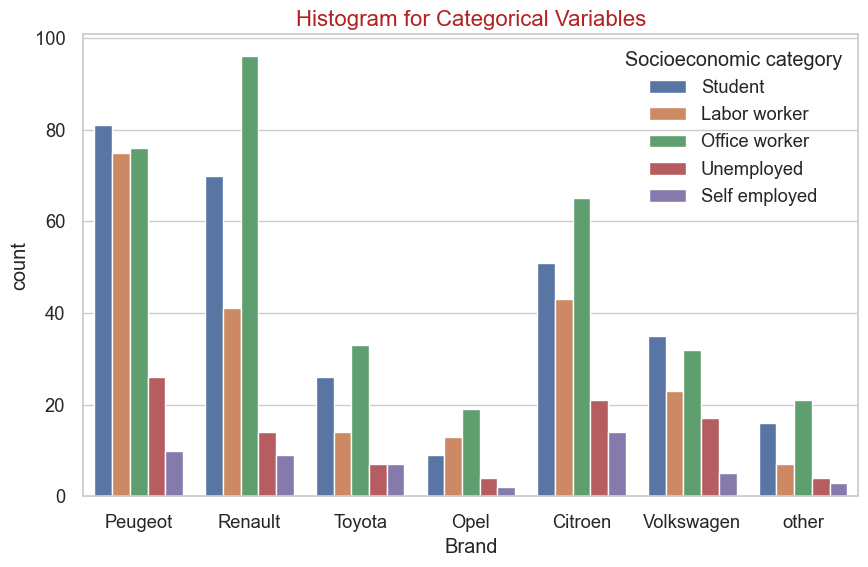

In [58]:

# create histogram here for categorical variables:
plt.figure(figsize=(10,6))
sns.set(style="whitegrid", font_scale=1.2)

chart = sns.countplot(x='Brand', hue='Socioeconomic category', data=modeling_data, palette='deep')

# Update layout parameters
chart.set_title('Histogram for Categorical Variables', fontsize=16, color='firebrick')
# Show the plot
plt.show()


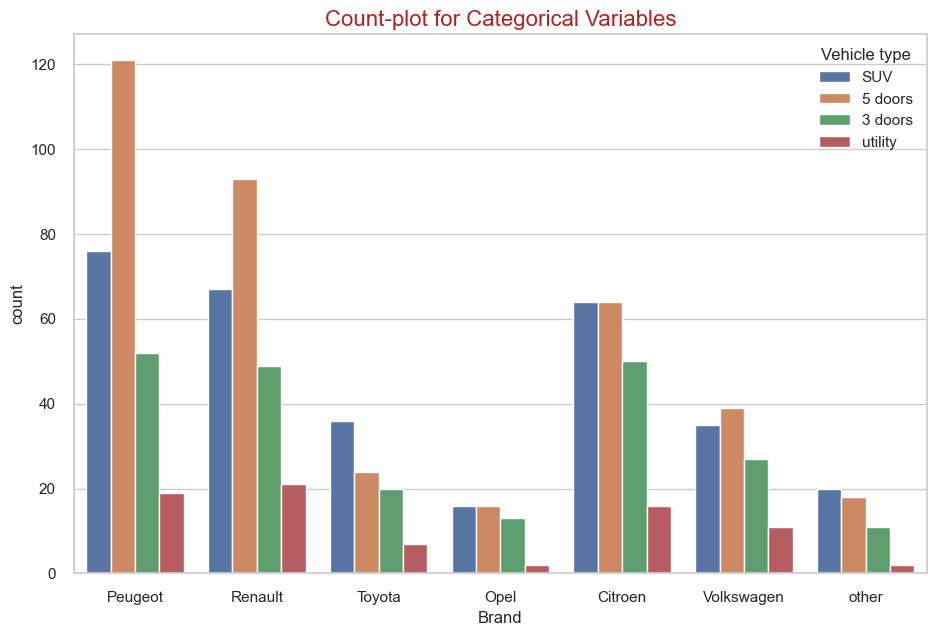

In [59]:

# set the style and figure size
sns.set(style="whitegrid")
plt.figure(figsize=(11,7))

# create the count-plot
chart = sns.countplot(x='Brand', hue='Vehicle type', data=modeling_data, palette='deep')

# update layout parameters
chart.set_title('Count-plot for Categorical Variables', fontsize=16, color='firebrick')

# Show the plot
plt.show()



There are few extreme outliers in the data, we might suspect a data entry problem:

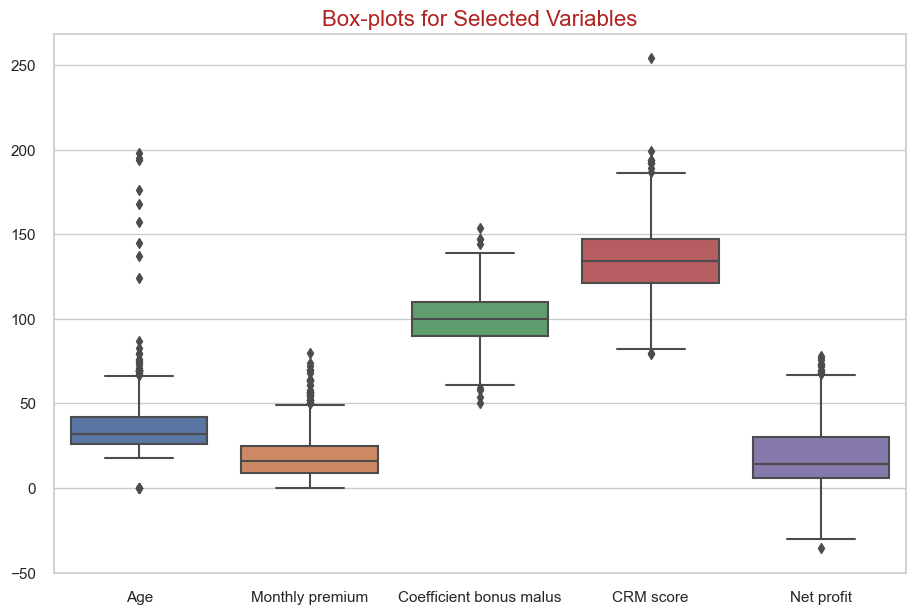

In [60]:


# Create a larger figure
plt.figure(figsize=(11,7))
# Create box-plots for each variable
sns.boxplot(data=modeling_data[["Age", "Monthly premium", "Coefficient bonus malus", "CRM score", "Net profit"]])
# Set plot title and labels
plt.title('Box-plots for Selected Variables', fontsize=16, color='firebrick')

# Show the plot
plt.show()



In [61]:

# drop extreme outlier from the above observations:
modeling_data = modeling_data[modeling_data["CRM score"] < 254]
modeling_data = modeling_data[(modeling_data["Age"] < 124) & (modeling_data["Age"] > 0)]


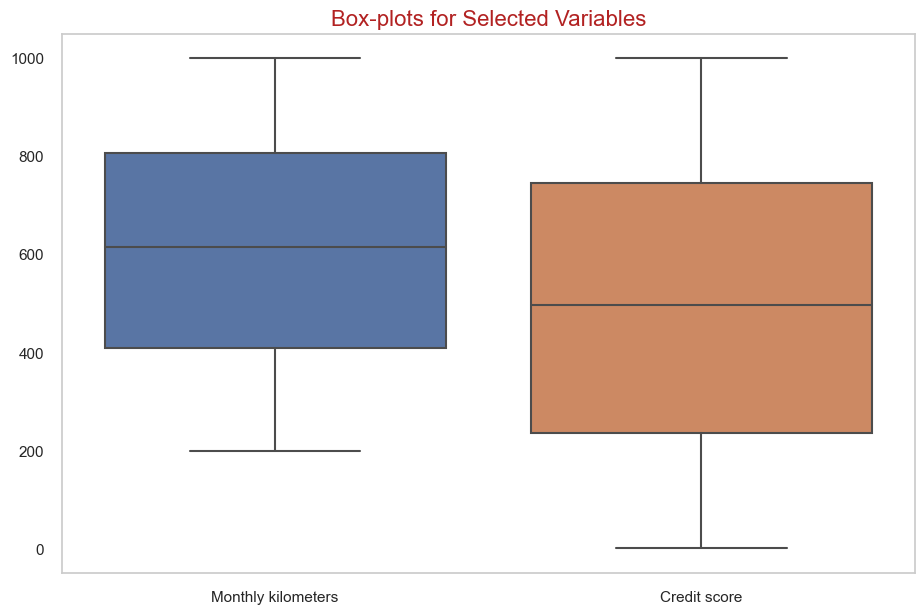

In [62]:

# no warning outlier for credit score, monthly kilometers and yearly maintenance cost:
# Create a larger figure
plt.figure(figsize=(11,7))

# Create box-plots for each variable
sns.boxplot(data=modeling_data[["Monthly kilometers", "Credit score"]])

# Set plot title and labels
plt.title('Box-plots for Selected Variables', fontsize=16, color='firebrick')

# remove background color
plt.grid(False)

# Show the plot
plt.show()




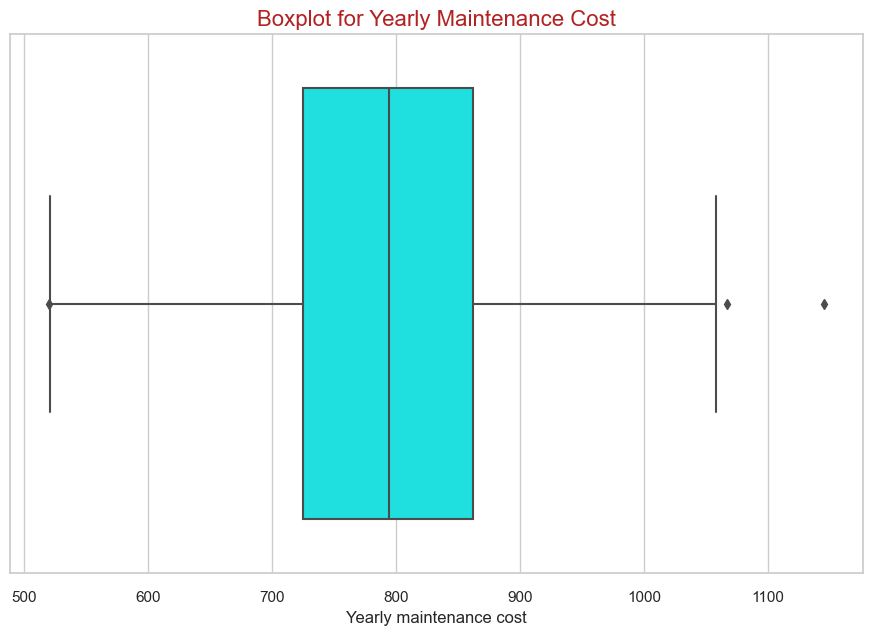

In [63]:

# Create a larger figure
plt.figure(figsize=(11,7))

# Create boxplot for the variable
sns.boxplot(x=modeling_data["Yearly maintenance cost"], color='aqua')

# Set plot title and labels
plt.title('Boxplot for Yearly Maintenance Cost', fontsize=16, color='firebrick')

# remove background color

# Show the plot
plt.show()


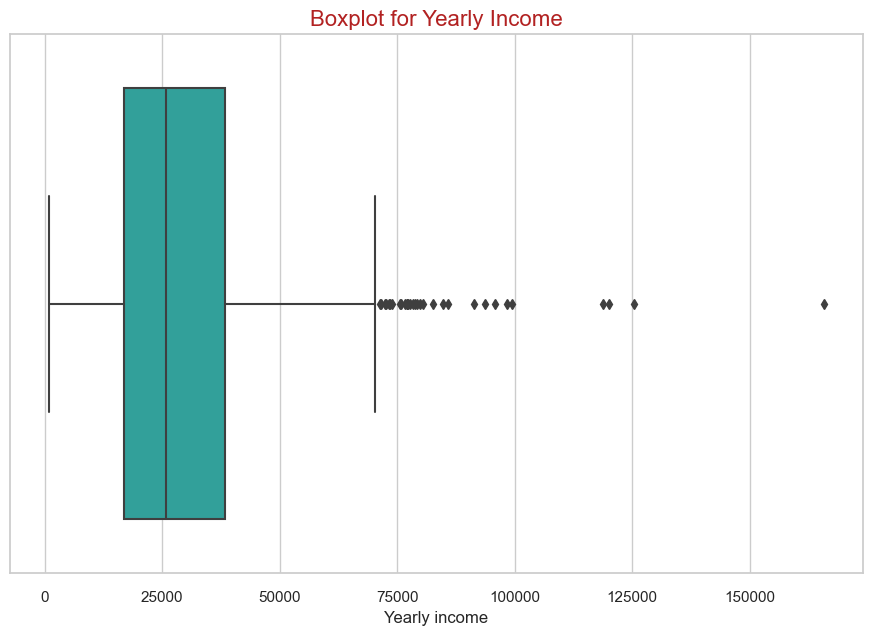

In [64]:

# Create a larger figure
plt.figure(figsize=(11,7))

# Create boxplot for the variable
sns.boxplot(x=modeling_data["Yearly income"], color='lightseagreen')

# Set plot title and labels
plt.title('Boxplot for Yearly Income', fontsize=16, color='firebrick')


# Show the plot
plt.show()


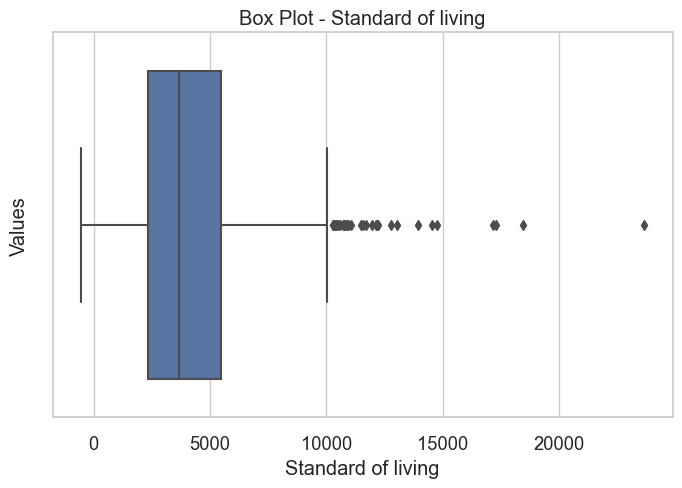

In [65]:


sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8, 5))

sns.boxplot(x=modeling_data["Standard of living"])

plt.xlabel("Standard of living")
plt.ylabel("Values")
plt.title("Box Plot - Standard of living")

plt.show()



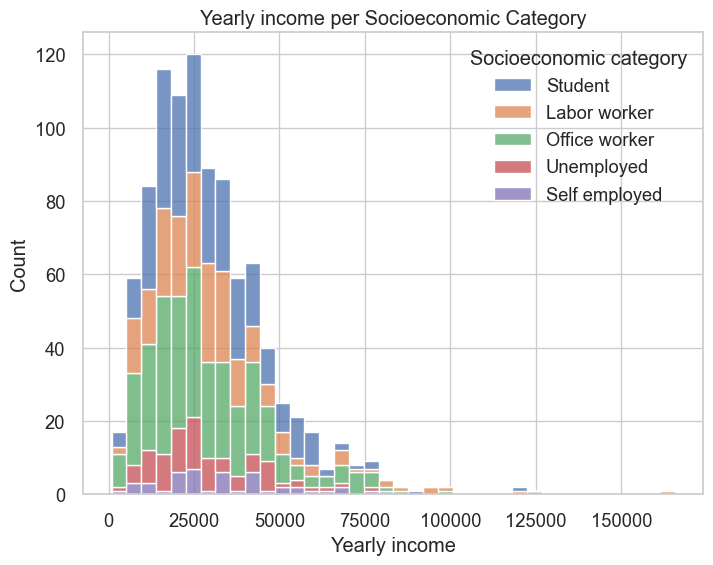

In [66]:


sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8, 6))

sns.histplot(data=modeling_data, x="Yearly income", hue="Socioeconomic category", multiple="stack")

plt.xlabel("Yearly income")
plt.ylabel("Count")
plt.title("Yearly income per Socioeconomic Category")

plt.show()



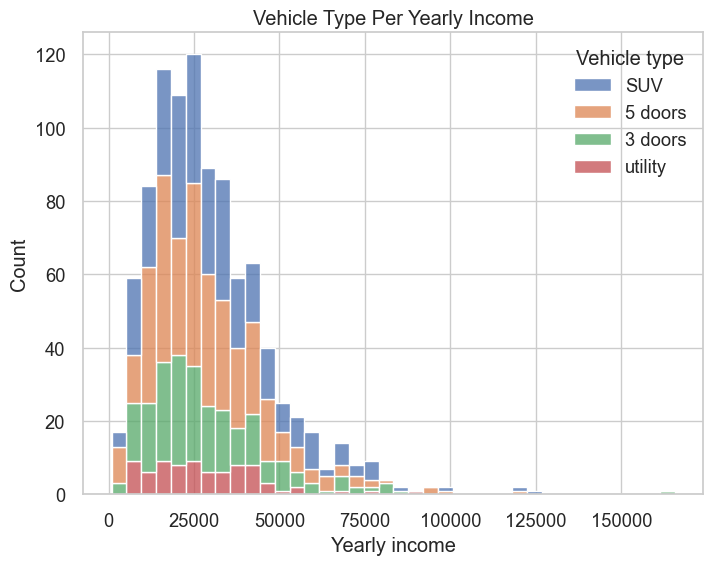

In [67]:

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8, 6))

sns.histplot(data=modeling_data, x="Yearly income", hue="Vehicle type", multiple="stack")

plt.xlabel("Yearly income")
plt.ylabel("Count")
plt.title("Vehicle Type Per Yearly Income")

plt.show()



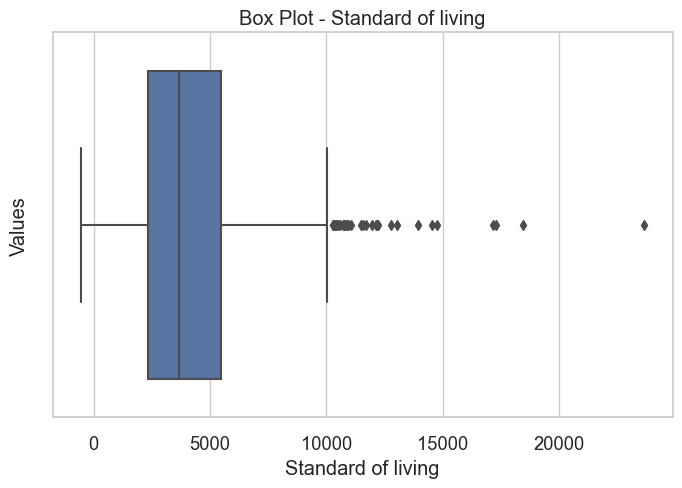

In [68]:
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8, 5))

sns.boxplot(x=modeling_data["Standard of living"])

plt.xlabel("Standard of living")
plt.ylabel("Values")
plt.title("Box Plot - Standard of living")

plt.show()

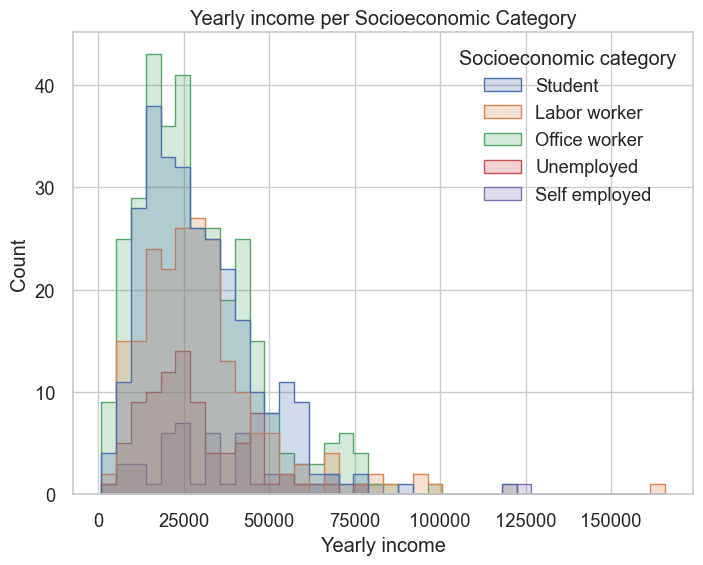

In [69]:
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8, 6))

sns.histplot(data=modeling_data, x="Yearly income", hue="Socioeconomic category", element="step")

plt.xlabel("Yearly income")
plt.ylabel("Count")
plt.title("Yearly income per Socioeconomic Category")

plt.show()

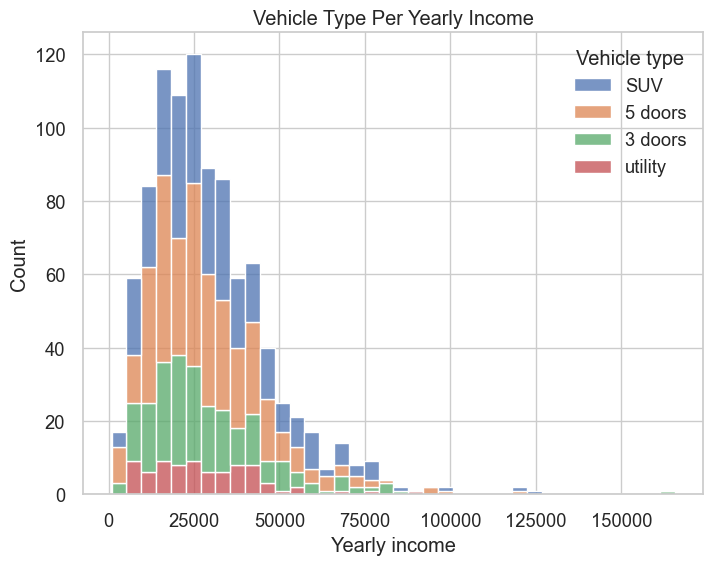

In [70]:
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8, 6))

sns.histplot(data=modeling_data, x="Yearly income", hue="Vehicle type", multiple="stack")

plt.xlabel("Yearly income")
plt.ylabel("Count")
plt.title("Vehicle Type Per Yearly Income")

plt.show()

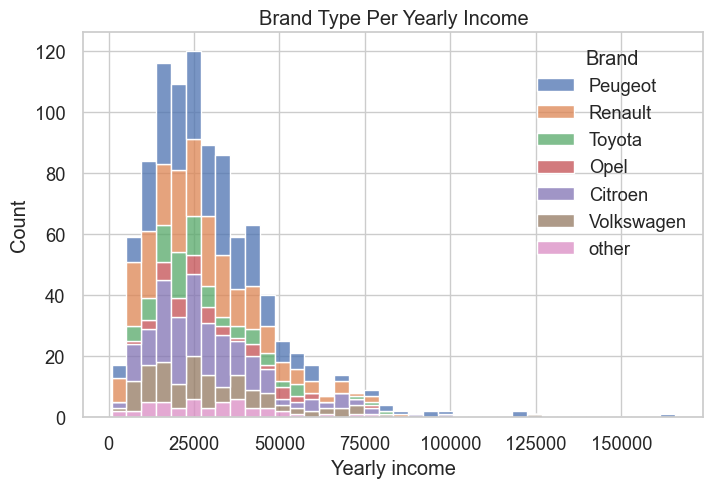

In [71]:

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8, 5))

sns.histplot(data=modeling_data, x="Yearly income", hue="Brand", multiple="stack")

plt.xlabel("Yearly income")
plt.ylabel("Count")
plt.title("Brand Type Per Yearly Income")

plt.show()


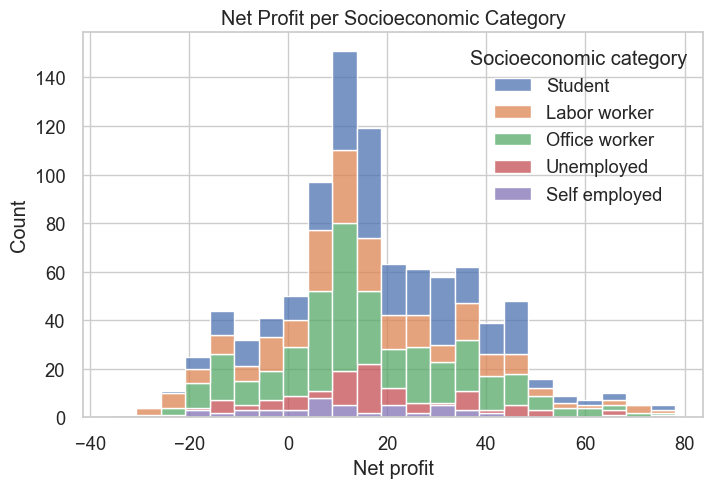

In [72]:
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8, 5))

sns.histplot(data=modeling_data, x="Net profit", hue="Socioeconomic category", multiple="stack")

plt.xlabel("Net profit")
plt.ylabel("Count")
plt.title("Net Profit per Socioeconomic Category")

plt.show()

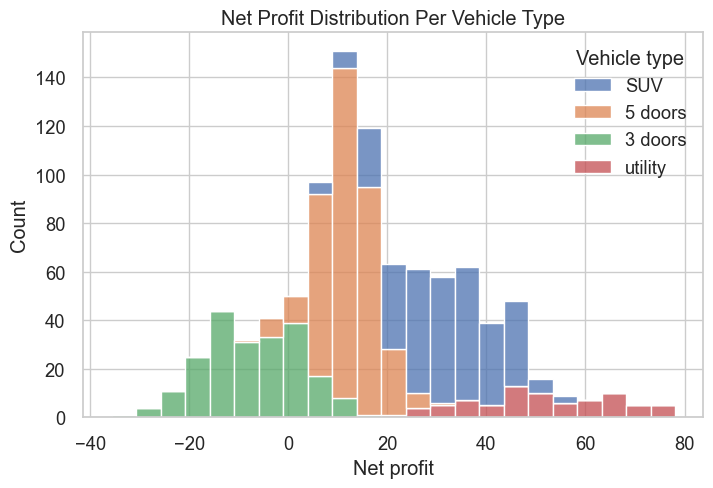

In [73]:
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8, 5))

sns.histplot(data=modeling_data, x="Net profit", hue="Vehicle type", multiple="stack")

plt.xlabel("Net profit")
plt.ylabel("Count")
plt.title("Net Profit Distribution Per Vehicle Type")

plt.show()

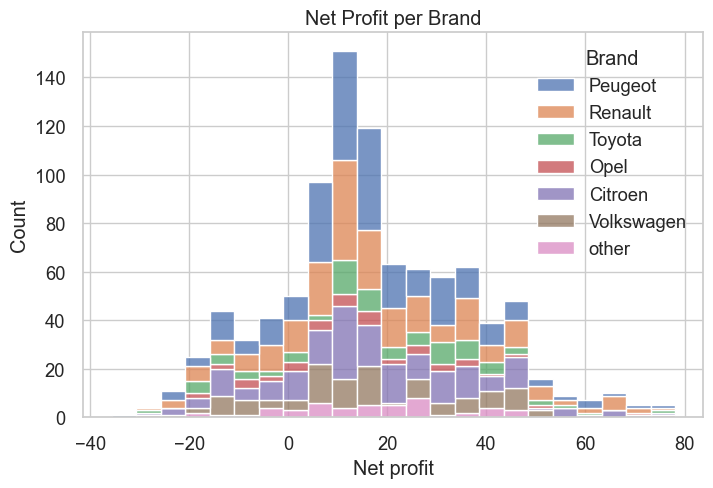

In [74]:
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8, 5))

sns.histplot(data=modeling_data, x="Net profit", hue="Brand", multiple="stack")

plt.xlabel("Net profit")
plt.ylabel("Count")
plt.title("Net Profit per Brand")

plt.show()

### Observation

- No warning outliers seen in the data except for yearly income, CRM score and Age.
- Numerical data are normally distributed.

#### Encode categorical variables and clean data for modeling:

In [75]:

# categorize your variables here:
categories = [
    'Brand',
    'Vehicle type',
    'Socioeconomic category',
]
modeling_data_visualization = pd.get_dummies(modeling_data,
                               columns=categories,
                               drop_first=False)


In [76]:

modeling_data = pd.get_dummies(
                               modeling_data,
                               columns=categories,
                               drop_first=True
                               )



In [77]:

# rearrange columns:
ordered_corr_columns = modeling_data_visualization.copy()
ordered_corr_columns = ordered_corr_columns[['Age',
                                             'Monthly premium',
                                             'Monthly kilometers',
                                             'Coefficient bonus malus',
                                             'CRM score',
                                             'Standard of living',
                                             'Yearly income',
                                             'Credit score',
                                             'Yearly maintenance cost',
                                             'Brand_Citroen',
                                             'Brand_Opel',
                                             'Brand_Peugeot',
                                             'Brand_Renault',
                                             'Brand_Toyota',
                                             'Brand_Volkswagen',
                                             'Brand_other',
                                             'Vehicle type_3 doors',
                                             'Vehicle type_5 doors',
                                             'Vehicle type_SUV',
                                             'Vehicle type_utility',
                                             'Socioeconomic category_Labor worker',
                                             'Socioeconomic category_Office worker',
                                             'Socioeconomic category_Self employed',
                                             'Socioeconomic category_Student',
                                             'Socioeconomic category_Unemployed',
                                             'Net profit'
                                             ]]


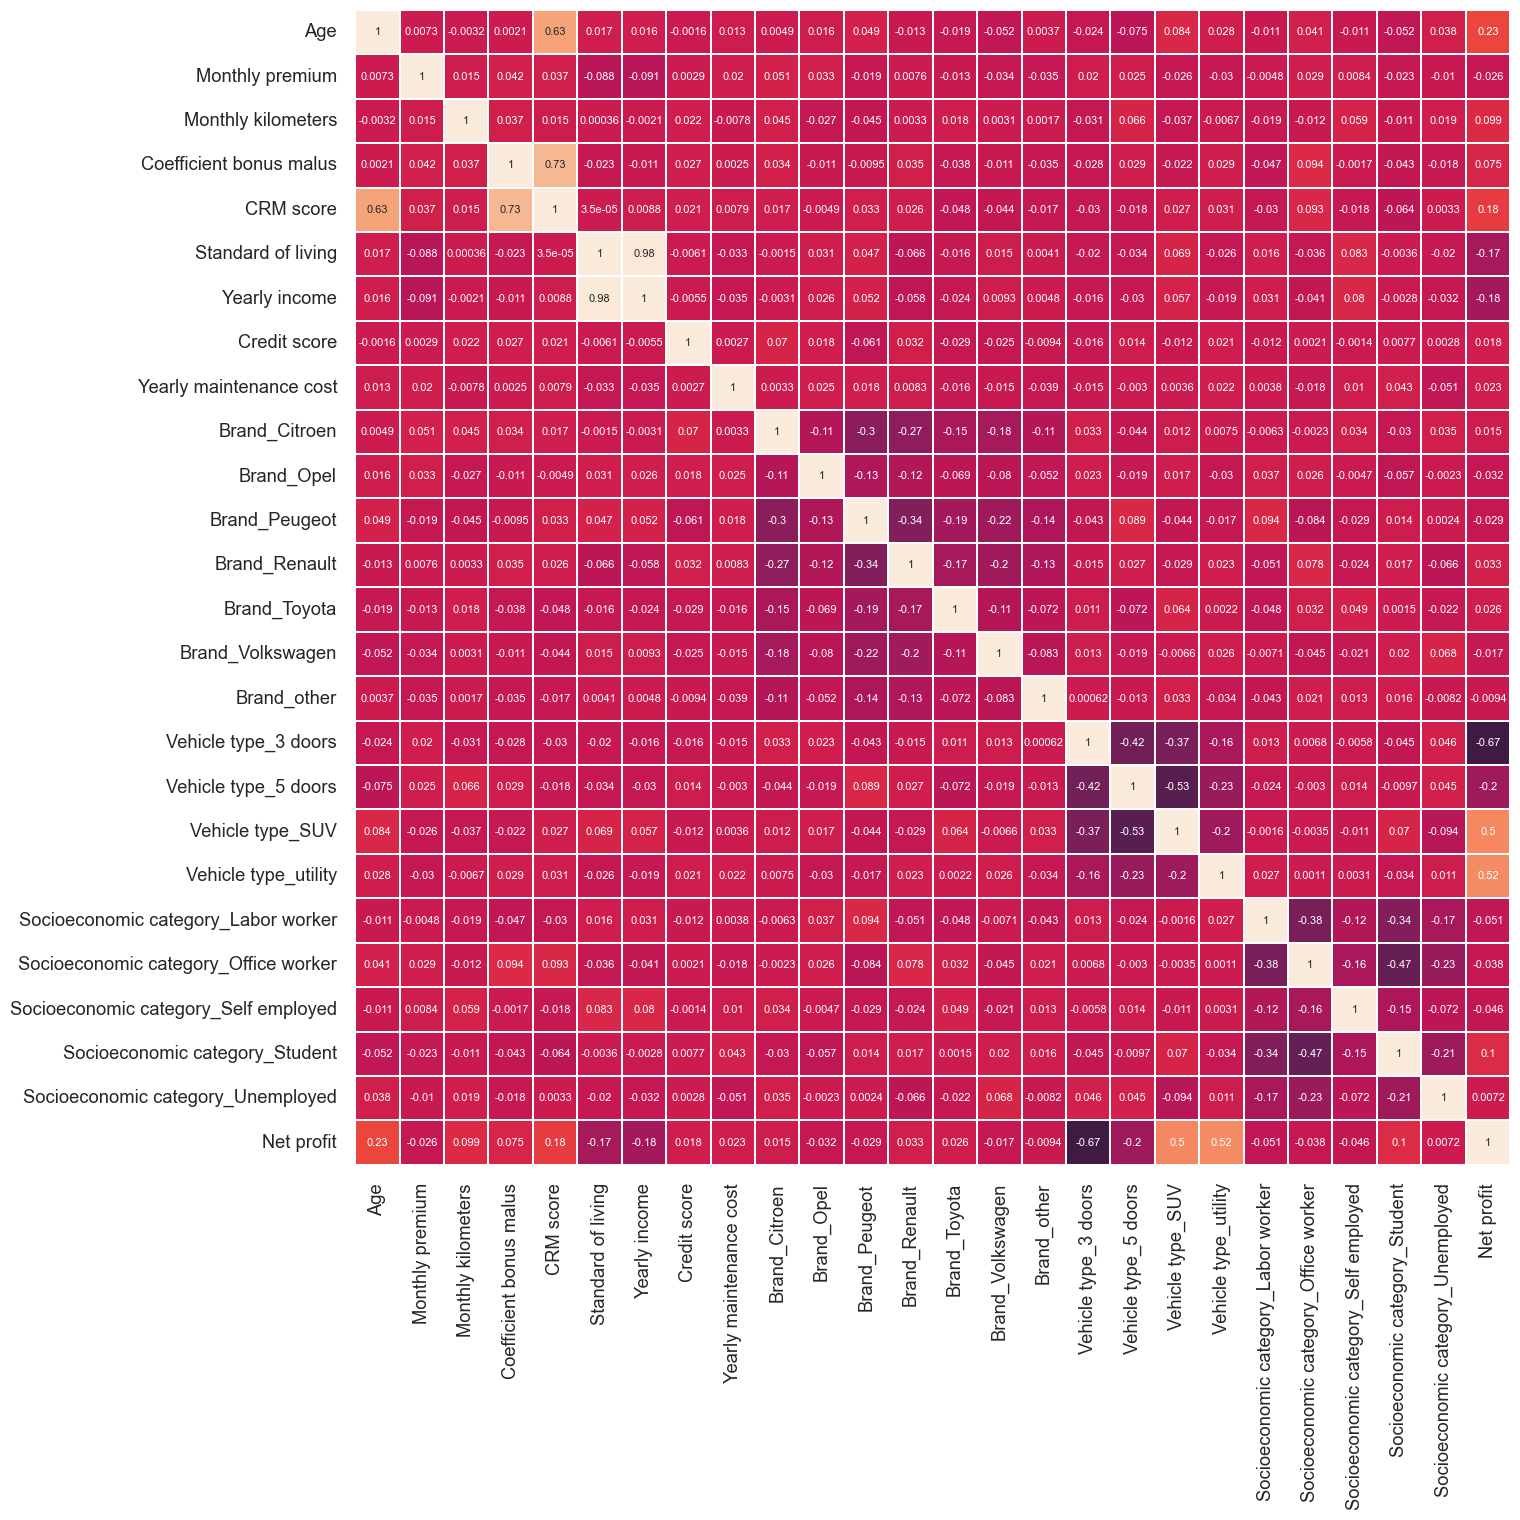

In [78]:

plt.figure(figsize=(15, 15))
corr = ordered_corr_columns.corr()
corr_top = corr.index
sns.heatmap(modeling_data_visualization[corr_top].corr(), vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 8},
            square=True, cbar=False);


<Axes: >

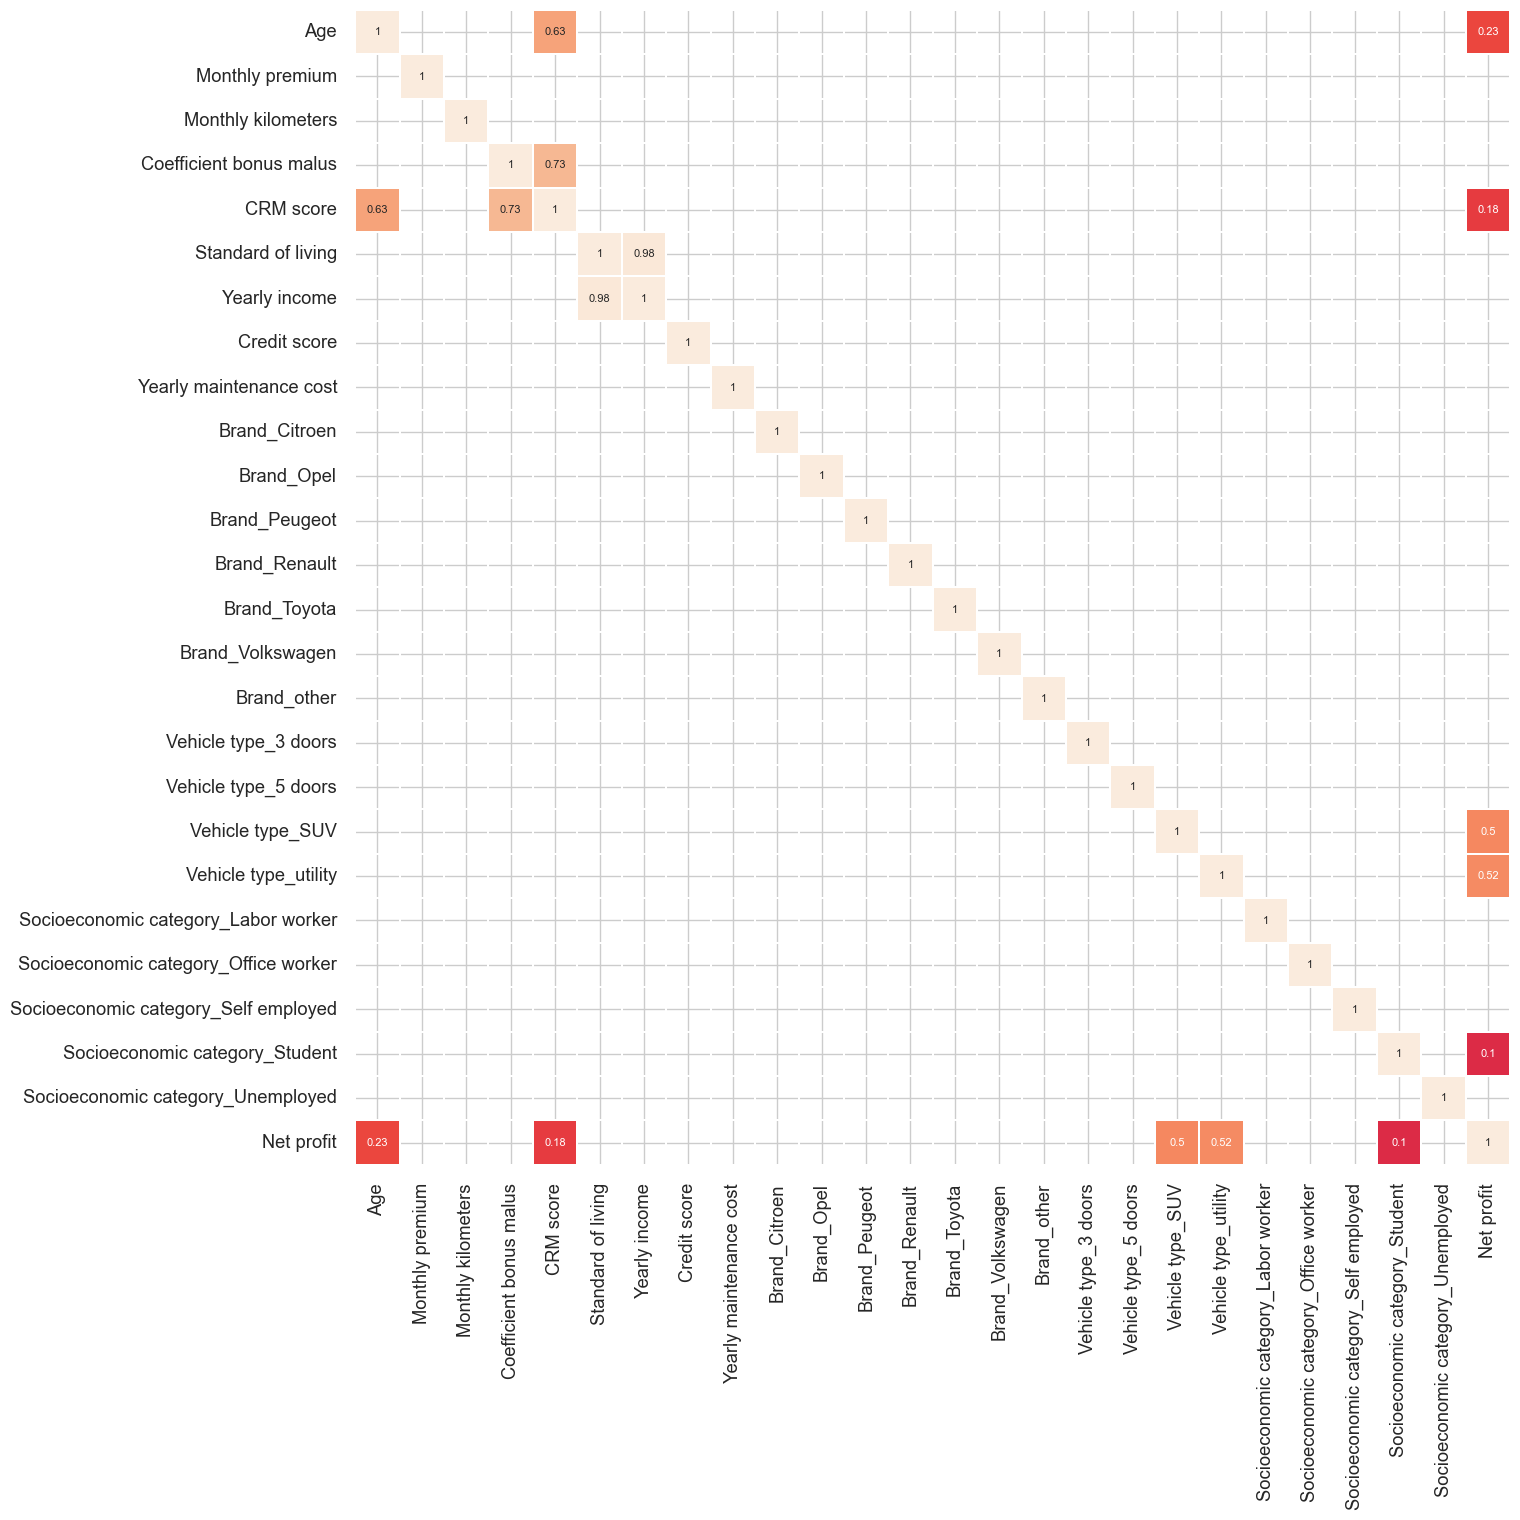

In [79]:

corr = ordered_corr_columns.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr[(corr >= 0.1)], vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 8}, square=True, cbar=False)



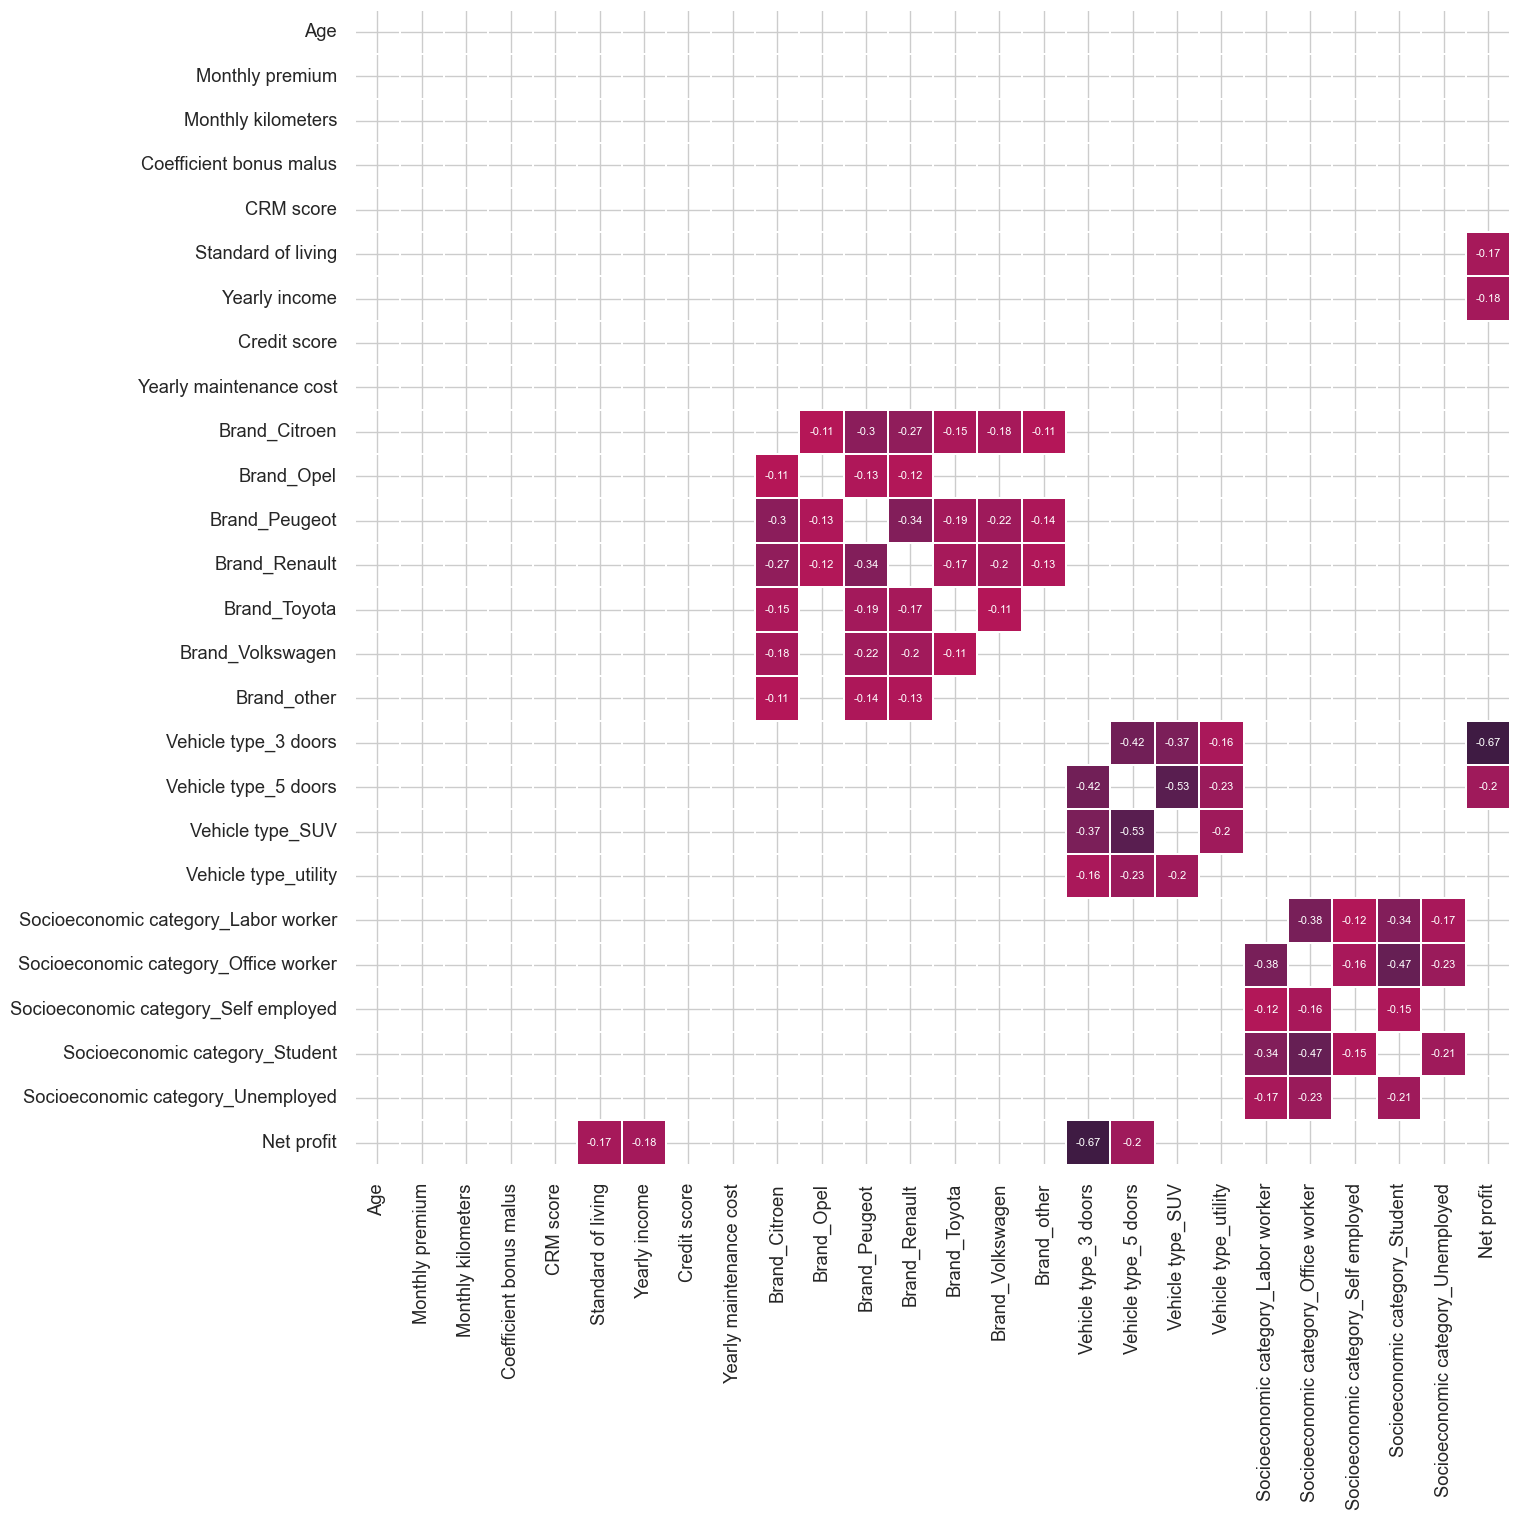

In [80]:

corr = ordered_corr_columns.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr[(corr <= -0.1)], vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 8}, square=True, cbar=False);


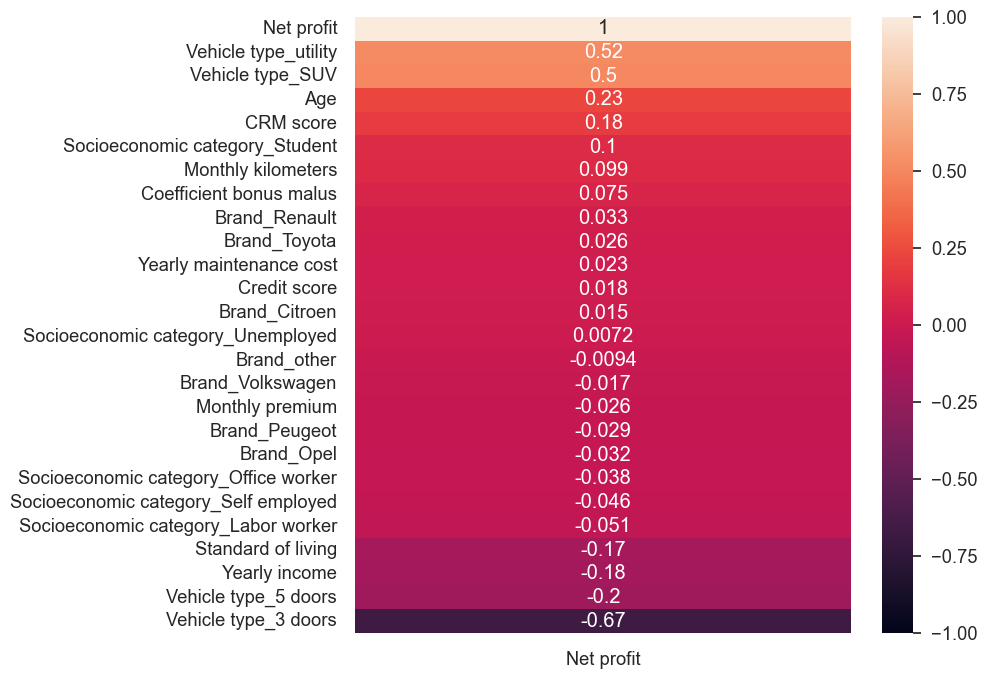

In [81]:

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(modeling_data_visualization.corr()[["Net profit"]].sort_values("Net profit"), vmax=1, vmin=-1, annot=True, ax=ax)
ax.invert_yaxis()


### Observation

- There is not any warning high correlation between target variable and independent variables.
- Multi-collinearity between Standard of living and yearly income, CRM score and Coefficient bonus malus, they might be problematic for linear models interpretation.
- There are few independent variables can be used for fitting model that correlate positively/negatively with Net profit.
- There is enough signals in the data simple model with fewer coefficient would generalize on unseen data.


### Simple Model:

In [82]:

Features = modeling_data.columns.tolist()
Features.remove("Net profit")
Ys = modeling_data["Net profit"]
Xs = modeling_data[Features]


Multi-collinearity Check VIF:


In [83]:

calculate_vif(Xs).style.background_gradient(cmap='summer')


,variables,VIF
0,Age,63.237779
1,Monthly premium,3.050082
2,Monthly kilometers,7.627456
3,Coefficient bonus malus,432.507997
4,CRM score,718.673947
5,Standard of living,110.184626
6,Yearly income,115.704855
7,Credit score,3.866306
8,Yearly maintenance cost,35.804418
9,Brand_Opel,1.240398


In [84]:

fixed_Xs = Xs.drop(["Standard of living", "Coefficient bonus malus","CRM score","Yearly maintenance cost"], axis=1)
calculate_vif(fixed_Xs).style.background_gradient(cmap='summer')


,variables,VIF
0,Age,7.099762
1,Monthly premium,2.836646
2,Monthly kilometers,6.413401
3,Yearly income,3.427115
4,Credit score,3.583600
5,Brand_Opel,1.204267
6,Brand_Peugeot,2.175342
7,Brand_Renault,2.026626
8,Brand_Toyota,1.377058
9,Brand_Volkswagen,1.472219


In [85]:

simple_model = LinearRegression().fit(fixed_Xs, Ys)
simple_model.score(fixed_Xs, Ys)


0.8834266631920002

In [86]:

coef = get_regressor_coefficients(simple_model, fixed_Xs.columns.tolist())


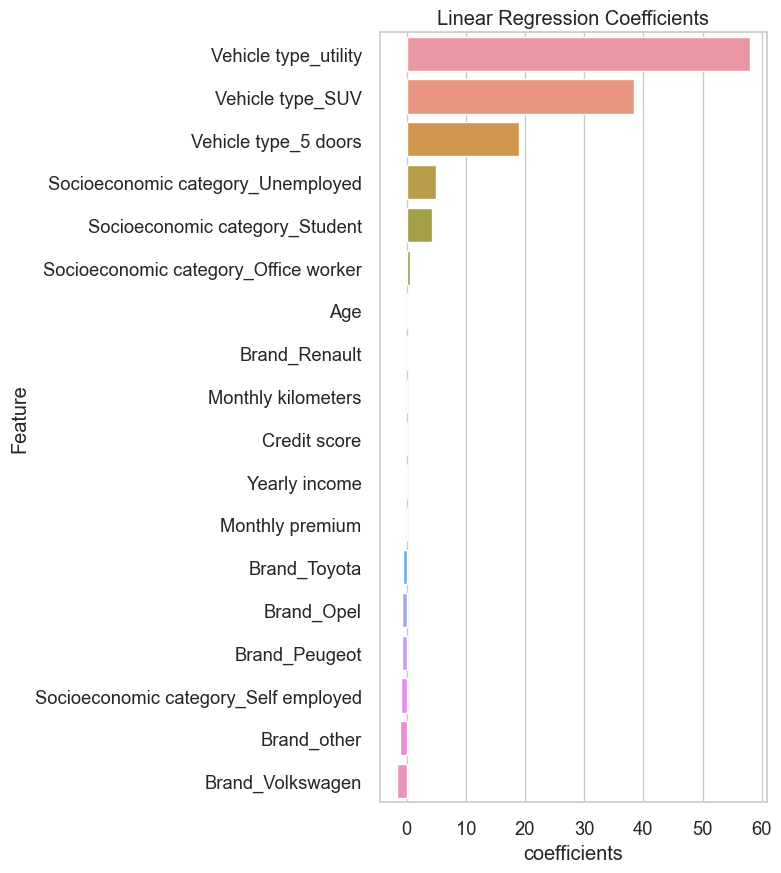

In [87]:

coefficient_plot(coef.values(), coef.keys())


In [88]:

est = OLS(Ys, Xs).fit()
print(est.summary())


                                 OLS Regression Results                                
Dep. Variable:             Net profit   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              569.0
Date:                Mon, 26 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:46:44   Log-Likelihood:                         -3203.3
No. Observations:                 958   AIC:                                      6451.
Df Residuals:                     936   BIC:                                      6558.
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------

In [89]:

statistical_results_as_frame = get_dataframe_from_summary(est)
statistical_results_as_frame[statistical_results_as_frame["P>|t|"] <= 0.000].style.background_gradient(cmap='summer')


,coef,std err,t,P>|t|,[0.025,0.975]
Age,0.214800,0.048000,4.474000,0.000000,0.121000,0.309000
Monthly kilometers,0.007200,0.001000,7.597000,0.000000,0.005000,0.009000
Yearly income,-0.000300,0.000069,-3.946000,0.000000,-0.000000,-0.000000
Yearly maintenance cost,-0.013900,0.002000,-8.276000,0.000000,-0.017000,-0.011000
Vehicle type_5 doors,18.336400,0.600000,30.537000,0.000000,17.158000,19.515000
Vehicle type_SUV,37.858700,0.621000,60.937000,0.000000,36.639000,39.078000
Vehicle type_utility,57.458300,0.921000,62.415000,0.000000,55.652000,59.265000
Socioeconomic category_Student,3.593700,0.633000,5.676000,0.000000,2.351000,4.836000
Socioeconomic category_Unemployed,3.931000,0.887000,4.431000,0.000000,2.190000,5.672000


In [103]:

X_train, X_test, y_train, y_test = train_test_split(fixed_Xs, Ys, test_size=0.3, random_state=10101)


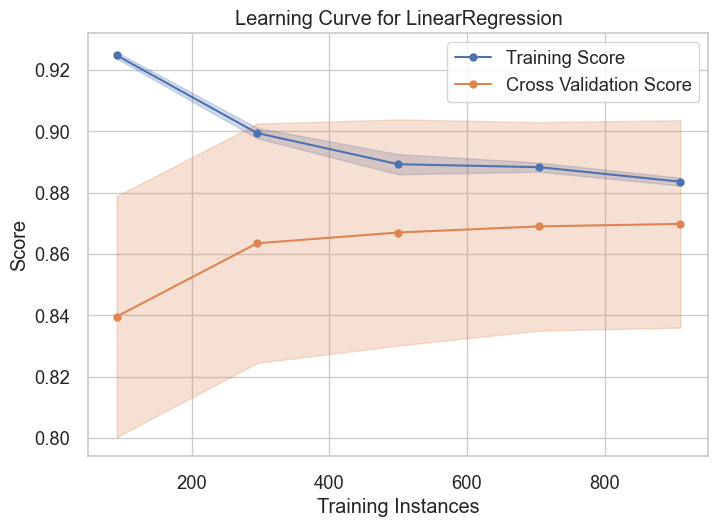

<Axes: title={'center': 'Learning Curve for LinearRegression'}, xlabel='Training Instances', ylabel='Score'>

In [99]:

visualizer = LearningCurve(
    simple_model, cv=20, scoring='r2',
    n_jobs=4
)
visualizer.fit(fixed_Xs,Ys )
visualizer.show()


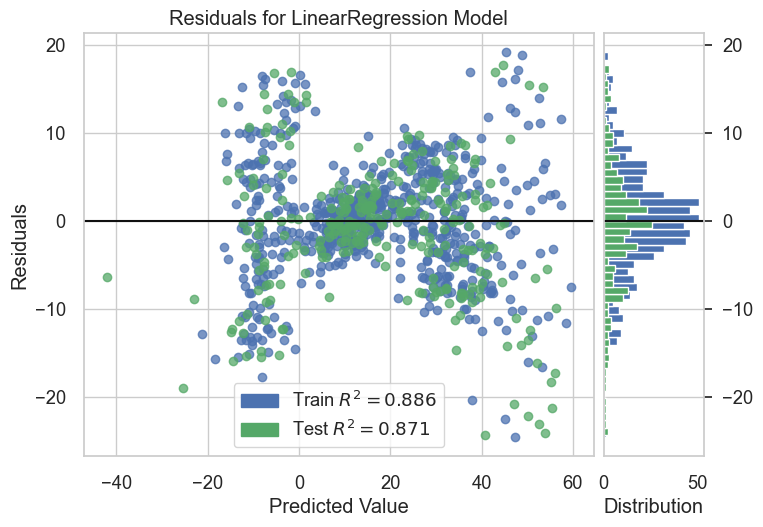

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [108]:
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


### Observation:
- As suspected Standard of living, yearly income and Coefficient bonus malus has strong correlation with other independent variables, they can be predicted by other independent variables.
- As suspected model is stable against few features, after dropping independent variables with high VIF scores 0.886
- P-values: Socioeconomic: student, unemployed, vehicle types 3,5 suv and utility, yearly income, age and monthly kilometers suggest strong significant relation between them and target variable on large populations.
- Brand Renault and Toyota P-values suggest strong influence on target variable compared to other brands.
- Residuals: indicates a good fit for linear model, predicted values greater than 40 are misfit for compared to the training samples.
- unexpected high p-value for Socioeconomic Self employed brand Volkswagen, Credit score and Yearly maintenance cost independent variables.
- Model tend to generalize when applying cross-validation of 20 folds, testing and training scores are matching after 20 folds/iterations.

## More Complex Model:
- From the above observation we have constructed a stable model with simple features and linear regressor, I would vote for simplified models since they are easy to explain to stakeholders and easier to productionize compared to more complex model with high variance.
- The fact that the data is synthetic and generated from known function makes it even easier to fit a model against normally distributed target variables.
- Tho it's not required for this particular dataset but the demonstration below will help explain what is happening behind the scene why applying a particular predictions.

In [109]:

from lightgbm import LGBMRegressor
import numpy as np

complex_model = LGBMRegressor(random_state=np.random.RandomState().get_state()[1][0])
complex_model.fit(X_train, y_train)


LGBMRegressor(random_state=2147483648)

In [110]:

{"training score": complex_model.score(X_train, y_train),
 "testing score": complex_model.score(X_test, y_test)}


{'training score': 0.9954600929824392, 'testing score': 0.9744489721140687}

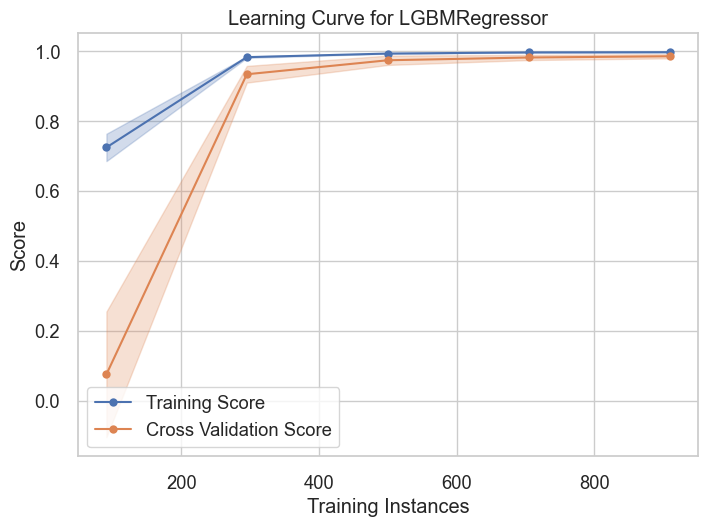

<Axes: title={'center': 'Learning Curve for LGBMRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [113]:

visualizer = LearningCurve(
    complex_model, cv=20, scoring='r2',
    n_jobs=4
)
visualizer.fit(fixed_Xs,Ys )
visualizer.show()



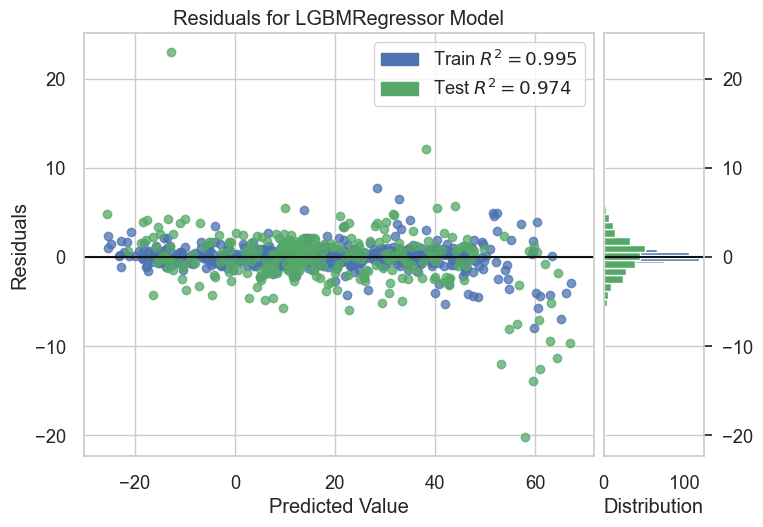

<Axes: title={'center': 'Residuals for LGBMRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [115]:

visualizer = ResidualsPlot(complex_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


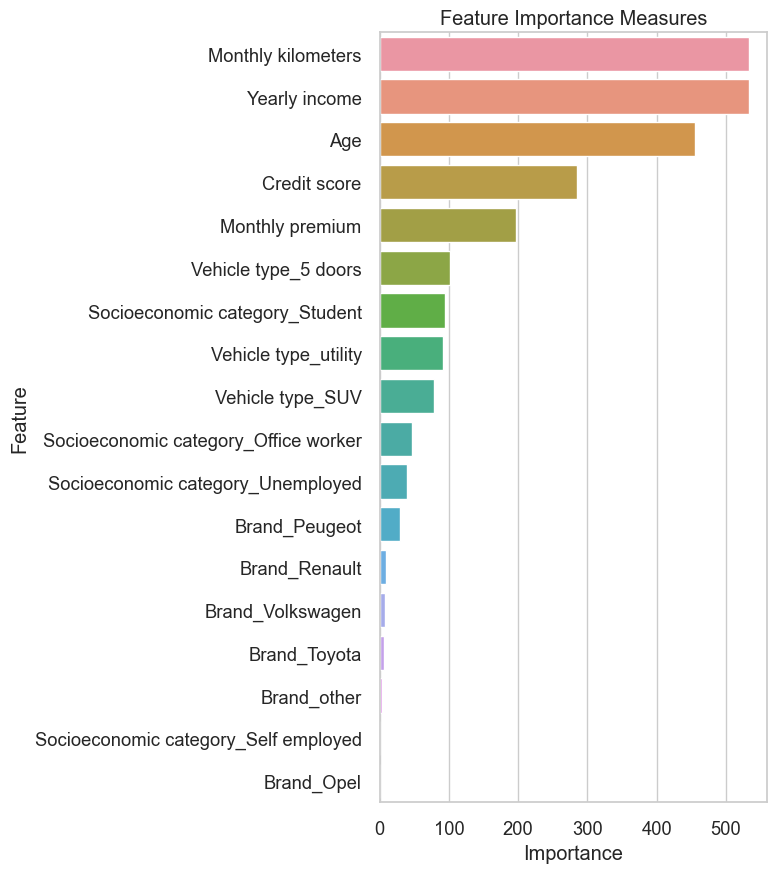

In [116]:

feature_importance_plot(complex_model.feature_importances_, X_train.columns.tolist())


In [117]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(fixed_Xs, Ys, test_size=0.3, random_state=10101)


In [118]:

complex_model.fit(X_train, y_train)
complex_model.score(X_test, y_test)


0.9744489721140687

In [119]:

{"training score": complex_model.score(X_train, y_train),
 "testing score": complex_model.score(X_test, y_test)}


{'training score': 0.9954600929824392, 'testing score': 0.9744489721140687}

In [120]:

complex_model.fit(fixed_Xs, Ys)


LGBMRegressor(random_state=2147483648)

In [121]:

save_model(complex_model, "lgb.pkl")


model saved....


### Observations:
- Baseline boosting model is accurate enough to generalize on unseen data.

### Predict on unseen Out-of-Sample Data:

In [122]:

golden_data = pd.read_csv("../../Data/scoring_dataset.csv")


In [123]:

golden_data = prepare_out_of_sample_data(golden_data)


In [124]:

predictions = complex_model.predict(golden_data)
predictions


array([ 58.91912859,  49.89491262,  55.44678162, -24.23093475,
       -14.2723258 ,  -8.53386753, -13.64680361,  -9.4624002 ,
        17.76568715,  11.00738228, -19.44384469,  13.65440611,
        10.68901548,  42.35671464,  64.73750346,  31.21405441,
        33.57720901,  66.54627244,  17.34307286, -17.41840316,
        10.57054402,  27.4537283 ,  69.35269097, -12.27879405,
        15.81947529,  -9.96537782,  -3.50549684,  10.60525138,
        29.81544625, -11.33242524,   7.88417464,  11.87869155,
       -21.32857179,  68.10191868,  34.02686042,  12.06295287,
         9.21788335,  11.4395712 , -22.66475147,  10.90707741,
       -11.89317256, -21.2898417 , -16.45650735,  58.73523363,
        11.32063774,  51.41548191,  -6.16929583, -17.21084875,
         8.84313568,  -0.23152295,  16.33390489,  -7.37397323,
        47.33042878,  11.59818288,  35.74334818,  31.79114097,
        31.00438204,  30.59942712,   3.56928081,  32.61225069,
        30.14717748, -16.59407291,  36.6298427 ,  34.46

In [125]:

golden_data_output = golden_data.copy()
golden_data_output["Predictions"] = predictions
golden_data_output.to_csv("../../Output Files/Data/prediction.csv")


### Analyze Predictions with SHAP values:

In [126]:

shap.initjs()
explainer = shap.TreeExplainer(complex_model)
shap_values = explainer.shap_values(golden_data, predictions, check_additivity=False)


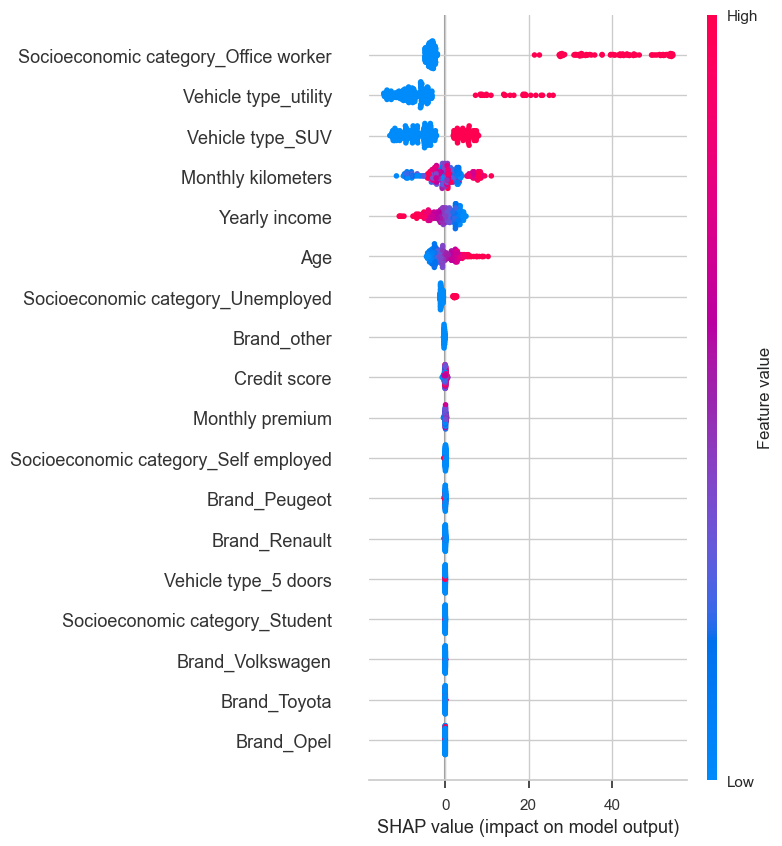

In [127]:

shap.summary_plot(shap_values, golden_data, max_display=len(golden_data.index))


#### Observations:
- Vehicle type 5 doors and SUV to blame for low Net-profit forecasting.
- Numerical variables Age and monthly kilometers and CRM score contributed the most for higher net profit.
- Other features such as Brands, Socioeconomic status has no effect compared to variables on the top.
- From feature importance plot it shows Yearly income, monthly kilometers, Age and CRM score are the most important factors in deciding net profit.
- It would be insightful to understand what to blame for high or low net profit from an out-of-sample dataset, as per individual forecasts.
- Higher age and monthly kilometers contributes higher net-profit, tho there are some cases where high value of age "red" decreases nonprofit, a dependence plot between two features will show how two similar values of monthly kilometers contributes differently to profit as it depends on interaction of two features.



### Individual Explanations of High and Low net profit forecasts.


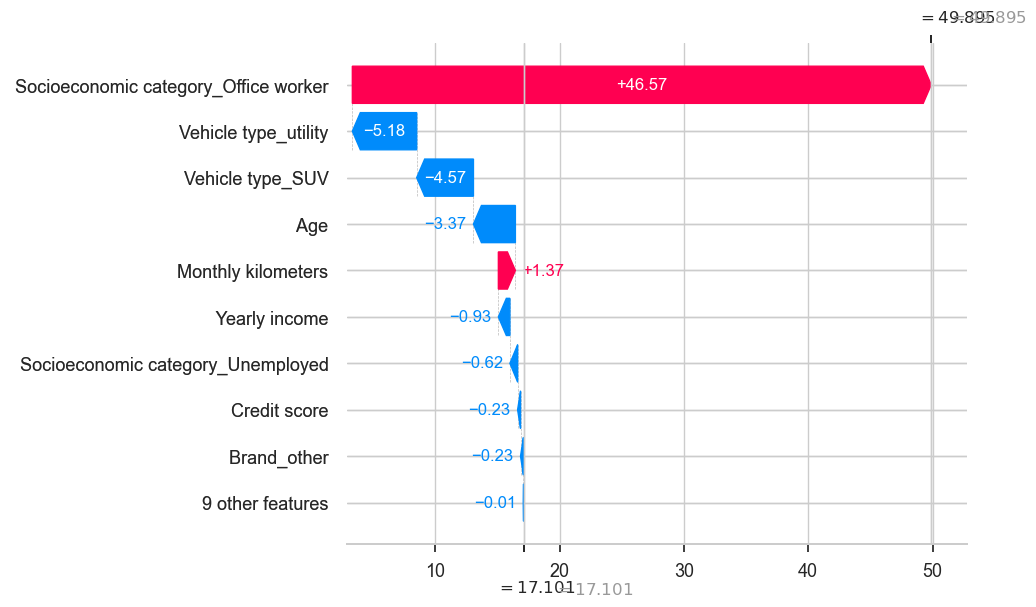

49.894912616226186


Age                                        21.0
Monthly premium                            14.0
Monthly kilometers                        694.0
Yearly income                           34900.0
Credit score                              833.0
Brand_Opel                                  1.0
Brand_Peugeot                               0.0
Brand_Renault                               0.0
Brand_Toyota                                0.0
Brand_Volkswagen                            0.0
Vehicle type_5 doors                        1.0
Vehicle type_SUV                            0.0
Vehicle type_utility                        0.0
Socioeconomic category_Office worker        1.0
Socioeconomic category_Self employed        0.0
Socioeconomic category_Student              0.0
Socioeconomic category_Unemployed           0.0
Brand_other                                 0.0
Name: 1001, dtype: float64

In [128]:

shap.plots._waterfall.waterfall_legacy(explainer.expected_value,
                                       shap_values[1],
                                       golden_data.iloc[1],
                                       golden_data.columns)
print(predictions[1])
golden_data.iloc[1]


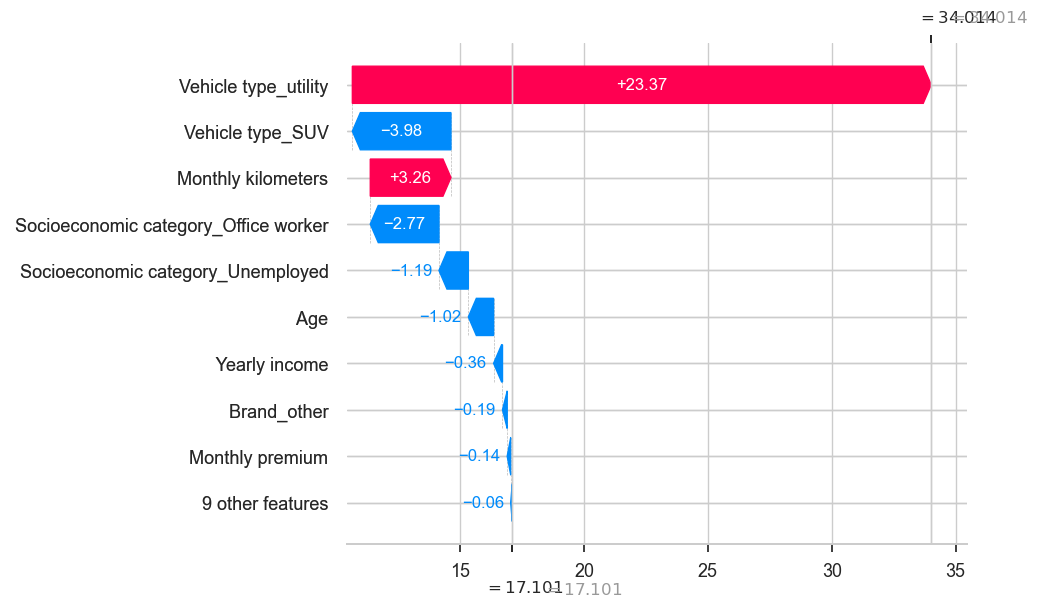

34.0143422063608


Age                                        33.0
Monthly premium                             8.0
Monthly kilometers                        748.0
Yearly income                           32360.0
Credit score                              271.0
Brand_Opel                                  1.0
Brand_Peugeot                               0.0
Brand_Renault                               0.0
Brand_Toyota                                0.0
Brand_Volkswagen                            0.0
Vehicle type_5 doors                        0.0
Vehicle type_SUV                            0.0
Vehicle type_utility                        1.0
Socioeconomic category_Office worker        0.0
Socioeconomic category_Self employed        0.0
Socioeconomic category_Student              1.0
Socioeconomic category_Unemployed           0.0
Brand_other                                 0.0
Name: 1298, dtype: float64

In [129]:


shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[292], golden_data.iloc[292],
                                       golden_data.columns)
print(predictions[292])
golden_data.iloc[292]


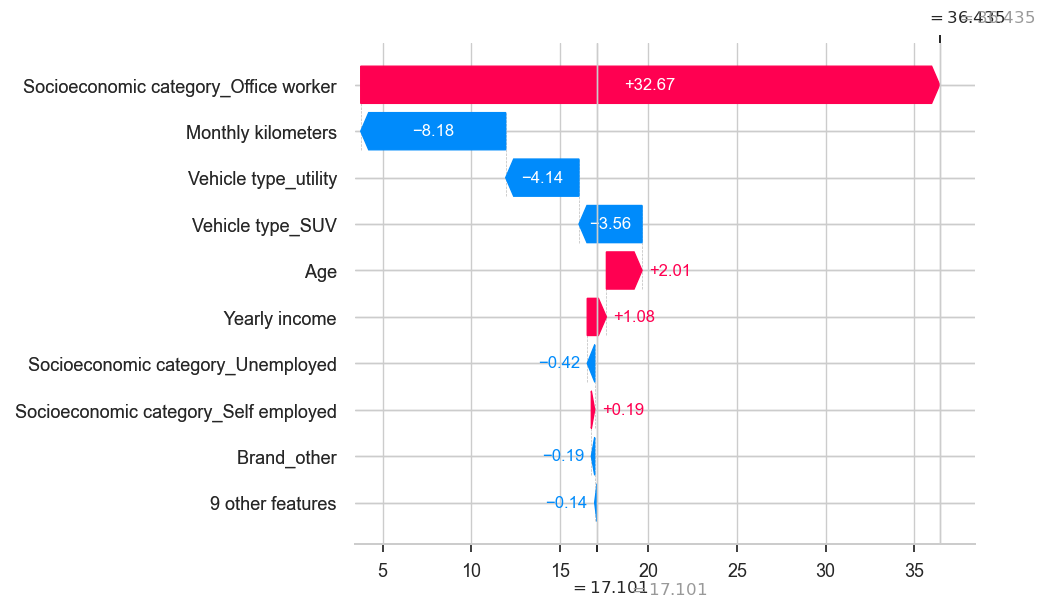

36.434799275715484


Age                                        42.0
Monthly premium                            15.0
Monthly kilometers                        345.0
Yearly income                           21730.0
Credit score                               78.0
Brand_Opel                                  0.0
Brand_Peugeot                               0.0
Brand_Renault                               0.0
Brand_Toyota                                0.0
Brand_Volkswagen                            0.0
Vehicle type_5 doors                        0.0
Vehicle type_SUV                            0.0
Vehicle type_utility                        0.0
Socioeconomic category_Office worker        1.0
Socioeconomic category_Self employed        0.0
Socioeconomic category_Student              0.0
Socioeconomic category_Unemployed           0.0
Brand_other                                 0.0
Name: 1190, dtype: float64

In [130]:

shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[185], golden_data.iloc[185],
                                       golden_data.columns)
print(predictions[185])
golden_data.iloc[185]


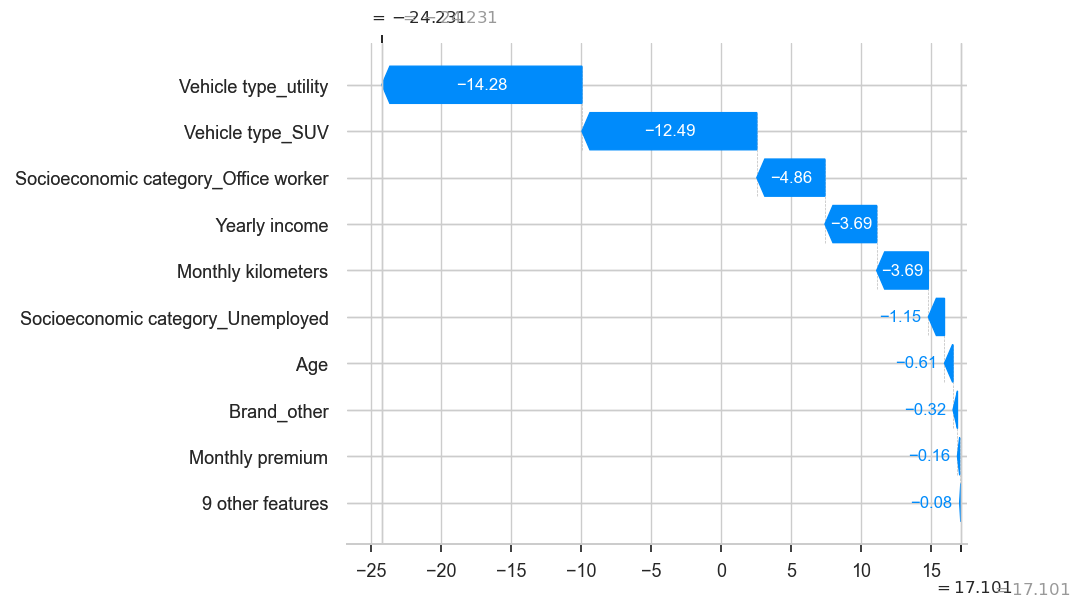

-24.23093475368557


Age                                        33.0
Monthly premium                             2.0
Monthly kilometers                        970.0
Yearly income                           45450.0
Credit score                              990.0
Brand_Opel                                  0.0
Brand_Peugeot                               0.0
Brand_Renault                               0.0
Brand_Toyota                                0.0
Brand_Volkswagen                            0.0
Vehicle type_5 doors                        1.0
Vehicle type_SUV                            0.0
Vehicle type_utility                        0.0
Socioeconomic category_Office worker        0.0
Socioeconomic category_Self employed        0.0
Socioeconomic category_Student              1.0
Socioeconomic category_Unemployed           0.0
Brand_other                                 0.0
Name: 1003, dtype: float64

In [131]:

shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[3], golden_data.iloc[3],
                                       golden_data.columns)
print(predictions[3])
golden_data.iloc[3]


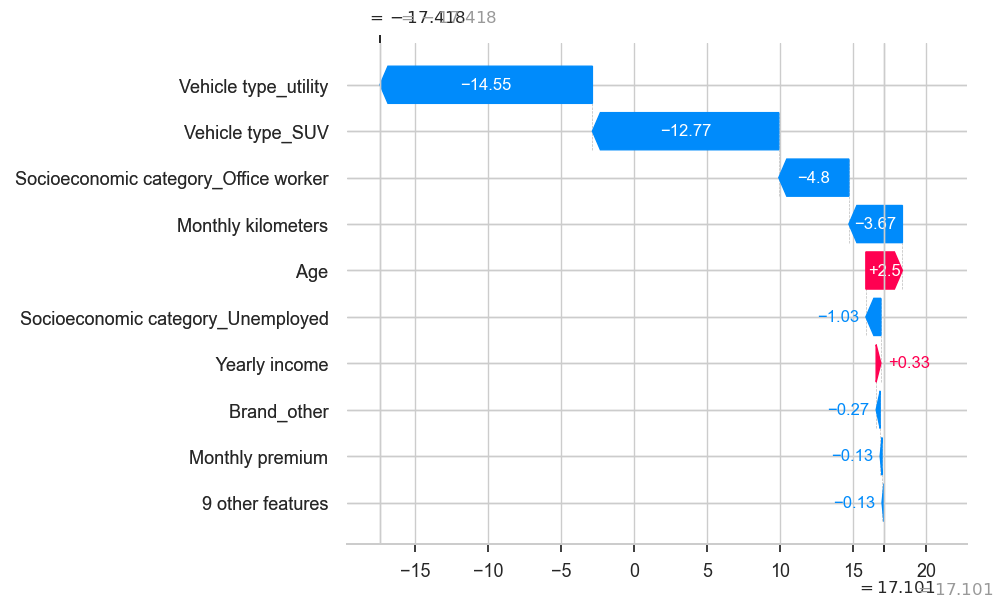

-17.41840315625436


Age                                        45.0
Monthly premium                             4.0
Monthly kilometers                        993.0
Yearly income                           29160.0
Credit score                              255.0
Brand_Opel                                  0.0
Brand_Peugeot                               0.0
Brand_Renault                               1.0
Brand_Toyota                                0.0
Brand_Volkswagen                            0.0
Vehicle type_5 doors                        0.0
Vehicle type_SUV                            0.0
Vehicle type_utility                        0.0
Socioeconomic category_Office worker        0.0
Socioeconomic category_Self employed        0.0
Socioeconomic category_Student              0.0
Socioeconomic category_Unemployed           0.0
Brand_other                                 0.0
Name: 1021, dtype: float64

In [132]:

shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[19], golden_data.iloc[19],
                                       golden_data.columns)
print(predictions[19])
golden_data.iloc[19]


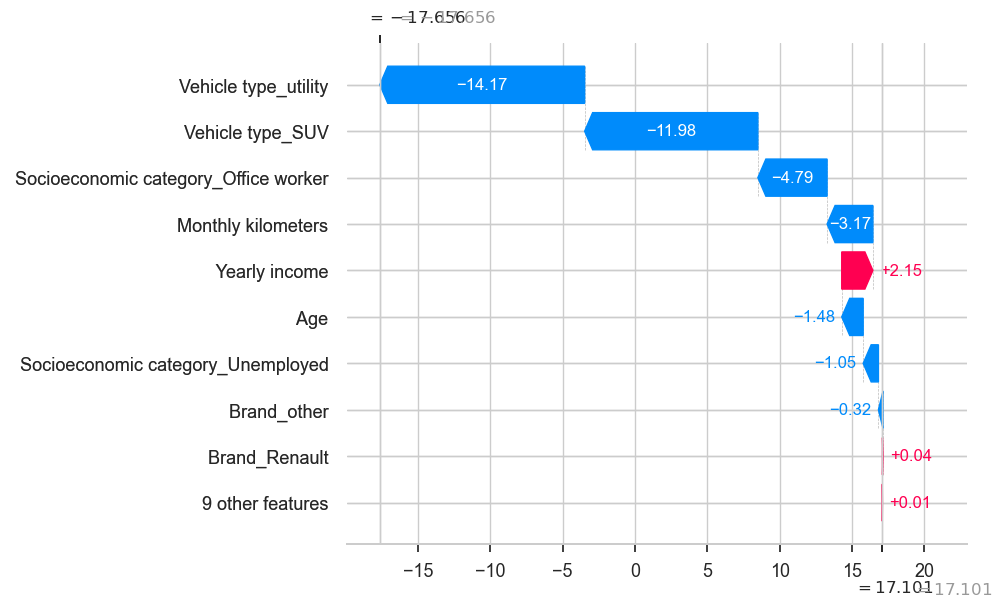

-17.65590834806663


Age                                        30.0
Monthly premium                            27.0
Monthly kilometers                        915.0
Yearly income                           19460.0
Credit score                              746.0
Brand_Opel                                  0.0
Brand_Peugeot                               1.0
Brand_Renault                               0.0
Brand_Toyota                                0.0
Brand_Volkswagen                            0.0
Vehicle type_5 doors                        0.0
Vehicle type_SUV                            0.0
Vehicle type_utility                        0.0
Socioeconomic category_Office worker        0.0
Socioeconomic category_Self employed        0.0
Socioeconomic category_Student              0.0
Socioeconomic category_Unemployed           0.0
Brand_other                                 0.0
Name: 1145, dtype: float64

In [133]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[140], golden_data.iloc[140],
                                       golden_data.columns)
print(predictions[140])
golden_data.iloc[140]


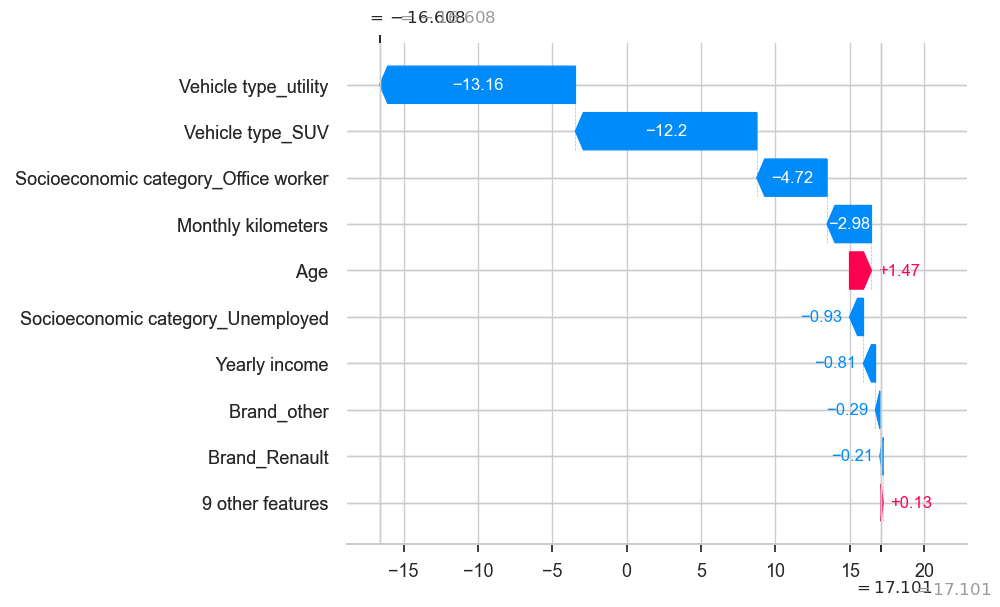

-16.60818486301198


Age                                        41.0
Monthly premium                             5.0
Monthly kilometers                        801.0
Yearly income                           32950.0
Credit score                              824.0
Brand_Opel                                  0.0
Brand_Peugeot                               0.0
Brand_Renault                               1.0
Brand_Toyota                                0.0
Brand_Volkswagen                            0.0
Vehicle type_5 doors                        0.0
Vehicle type_SUV                            0.0
Vehicle type_utility                        0.0
Socioeconomic category_Office worker        0.0
Socioeconomic category_Self employed        0.0
Socioeconomic category_Student              0.0
Socioeconomic category_Unemployed           0.0
Brand_other                                 0.0
Name: 1270, dtype: float64

In [134]:

shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[264], golden_data.iloc[264],
                                       golden_data.columns)
print(predictions[264])
golden_data.iloc[264]
